In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jun 23 21:03:25 2025

@author: alexanderpfaff
"""

from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten  
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.metrics import SparseCategoricalAccuracy 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix #, ConfusionMatrixDisplay, classification_report

import numpy as np

from PsQ_GridCollection import GridCollection as GC
import matplotlib.pyplot as plt


# The Syntax of Sudoku (Grids), Part Ib 


AlexPfaff, June-Aug 2025  
nonintersective@gmail.com 

<br>

## What's going on here? 

Multiclass classification, 15 classes: 
 - classes 1-14: horizontal permutation series  
 - class 0: garbage class, contains invalid grids + valid grids belonging to different permutation groups

<br> 

For more discussion, see 'psq_binary_clf.ipynb', 'The Syntax of Sudoku.pdf'; see module GridCollection for creation of datasets   
https://github.com/A-Lex-McLee/PseudoQ-2.1/tree/main  



In [2]:
# create a simple cnn model that takes vectorized sudoku grids as input
# multiclass classifier; labels -- classes = number of classes/labels in the dataset  

def make_CNN_classifier(oneHot: bool = True, classes: int = 5) -> Sequential:
    gshape: tuple = (9, 9, 9) if oneHot else (9, 9, 1) 
    loss = 'categorical_crossentropy' if oneHot else 'sparse_categorical_crossentropy' 
    
    inputs = Input(shape=gshape)
    x = Conv2D(81, kernel_size=3, activation='relu', padding='same')(inputs)
    x = Conv2D(135, kernel_size=3, activation='relu', padding='same')(x)
    x = Flatten()(x)
    x = Dense(81, activation='relu')(x)
    outputs = Dense(classes, activation='softmax')(x)
    model = Model(inputs, outputs)

    model.compile(
        optimizer='adam',    
        loss=loss,
        metrics=[SparseCategoricalAccuracy(name='accuracy'),
    ]) 
    return model


In [3]:
# NB: datasize =  class_count x 362880, thus 15 classes -> 5_443_200 datapoints. 
# this will roughly take between 2 and 4 hours, depending on your machine, GPU availability etc. 
# (it took a bit less then 3h on macbook, no GPU)
# If (run)time is an issue, try first a smaller class count, e.g. 7

class_count = 15
seed = 5213

In [4]:
# preparing and getting the data: 
#    15 labeled classes: 14 valid horizontal series (labels 1-14) + 1 garbage collection (label 0) 

gc = GC.from_scratch()

# diversify the garbage collection: various kinds of false grids 
#                                    + valid grids that belong to different permutation series
gc.activate_verticalSeries()
gc.makeFalseGrids_fromCurrent_switch()
gc.makeFalseGrids_arbitrary()
gc.makeFalseGrids_cardinality()
gc.make_guestGrids(series=5) 


# setting classes to class_count-1 because a garbage class will be added 
# by default, thus adding up to a total of class_count classes
gc.activate_multiClassSeries(classes=class_count-1) 


X_train, X_test, y_train, y_test = gc.split_multiclass(seed=seed)


# Current state of the GridCollection object
print(gc)

Recoding grids with top-row LUT: 100%|██████████| 1679616/1679616 [00:10<00:00, 160592.43it/s]


Generating guest grids, series 1: 


Generating 1296 X 1296 Grid Permutations: 100%|██████████| 1296/1296 [00:04<00:00, 263.10it/s]


Current size: 20000
Generating guest grids, series 2: 


Generating 1296 X 1296 Grid Permutations: 100%|██████████| 1296/1296 [00:04<00:00, 268.86it/s]


Current size: 40000
Generating guest grids, series 3: 


Generating 1296 X 1296 Grid Permutations: 100%|██████████| 1296/1296 [00:04<00:00, 269.45it/s]


Current size: 60000
Generating guest grids, series 4: 


Generating 1296 X 1296 Grid Permutations: 100%|██████████| 1296/1296 [00:04<00:00, 266.50it/s]


Current size: 80000
Generating guest grids, series 5: 


Generating 1296 X 1296 Grid Permutations: 100%|██████████| 1296/1296 [00:04<00:00, 267.24it/s]


Current size: 100000


Adding missing grids: 100%|██████████| 582/582 [00:00<00:00, 508241.71it/s]


GridCollection[ 
                 internal shape: (1679616, 81)  
                 active series: multiclass  	|	  size: 5443200  
                 labeled series: 15 classes  
                 labels: True   	|	  size: 5443200  
                 abc series: False  
                 garbage: True  	|	  size: 1979616 
					 guest_grids              : 100000
					 false_fromCurrent_seq    : 0
					 false_fromCurrent_switch : 1679616
					 false_cardinality        : 100000
					 false_off_by_X           : 0
					 false_arbitrary          : 100000 
               ] 


In [5]:
early_stop = EarlyStopping(
    monitor='val_loss',              
    patience=3,  
    restore_best_weights=True,
    verbose=2
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.51,          
    patience=2,        
    min_lr=1e-5,
    verbose=2
)

model = make_CNN_classifier(oneHot=False, classes=class_count) 
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 9, 9, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 9, 9, 81)       │           810 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 9, 9, 135)      │        98,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10935)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 81)             │       885,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,230 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 986,406 (3.76 MB)

 Trainable params: 986,406 (3.76 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# bringing the data in the shape required as input by the model;  NB: for oneHot encoded data: X_test.reshape(-1, 9, 9, 9)
X_train = X_train.reshape(-1, 9, 9, 1)       
X_test  = X_test.reshape(-1, 9, 9, 1) 

print("model in action:")
history = model.fit(X_train, y_train, 
                    batch_size=250,
                    epochs=15,
                    validation_split=0.25,
                    callbacks=[early_stop, reduce_lr],
                    shuffle=True)


model in action:
Epoch 1/15
13064/13064 ━━━━━━━━━━━━━━━━━━━━ 670s 51ms/step - accuracy: 0.9778 - loss: 0.0802 - val_accuracy: 0.9998 - val_loss: 7.3186e-04 - learning_rate: 0.0010
Epoch 2/15
13064/13064 ━━━━━━━━━━━━━━━━━━━━ 657s 50ms/step - accuracy: 0.9998 - loss: 0.0010 - val_accuracy: 0.9999 - val_loss: 4.7516e-04 - learning_rate: 0.0010
Epoch 3/15
13064/13064 ━━━━━━━━━━━━━━━━━━━━ 676s 52ms/step - accuracy: 0.9998 - loss: 9.5914e-04 - val_accuracy: 0.9999 - val_loss: 7.9604e-04 - learning_rate: 0.0010
Epoch 4/15
13064/13064 ━━━━━━━━━━━━━━━━━━━━ 674s 52ms/step - accuracy: 0.9998 - loss: 0.0011 - val_accuracy: 0.9999 - val_loss: 3.5811e-04 - learning_rate: 0.0010
Epoch 5/15
13064/13064 ━━━━━━━━━━━━━━━━━━━━ 676s 52ms/step - accuracy: 0.9999 - loss: 8.9908e-04 - val_accuracy: 0.9999 - val_loss: 7.7498e-04 - learning_rate: 0.0010
Epoch 6/15
13063/13064 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9999 - loss: 0.0011
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00051000002422

In [7]:
# evaluating the trained model  

X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

print("evaluating test set: ")
model.evaluate(X_test, y_test)
print()

print("evaluating the whole package: ")
model.evaluate(X, y)


evaluating test set: 
34020/34020 ━━━━━━━━━━━━━━━━━━━━ 90s 3ms/step - accuracy: 1.0000 - loss: 3.2055e-05

evaluating the whole package: 
170100/170100 ━━━━━━━━━━━━━━━━━━━━ 443s 3ms/step - accuracy: 1.0000 - loss: 5.7951e-06


[2.7771766326623037e-05, 0.9999983310699463]

In [8]:
# closer look at the predictions : test set 
pred_probs = model.predict(X_test)
y_preds = np.argmax(pred_probs, axis=1)

print(f"Test set:\n{(y_preds == y_test).sum()} " 
      f"out of {y_test.shape[0]} predicted correctly == " 
      f" {round((y_preds == y_test).sum()/y_test.shape[0] * 100,4)}%")


34020/34020 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step
Test set:
1088636 out of 1088640 predicted correctly ==  99.9996%


In [9]:
# closer look at the predictions : the entire dataset 
pred_probs = model.predict(X)
y_preds = np.argmax(pred_probs, axis=1)

print(f"Test set:\n{(y_preds == y).sum()} " 
      f"out of {y.shape[0]} predicted correctly == " 
      f" {round((y_preds == y).sum()/y.shape[0] * 100,4)}%")

170100/170100 ━━━━━━━━━━━━━━━━━━━━ 428s 3ms/step
Test set:
5443191 out of 5443200 predicted correctly ==  99.9998%


In [10]:
# confusion_matrix-oid
cm = confusion_matrix(y, y_preds) 

print("A sort-of Confusion Matrix; take a close look at where the mispredictions occur!\n")
for c, _class_ in enumerate(cm):
    print(f"Class {c:2d}  --  {list(_class_)}")


A sort-of Confusion Matrix; take a close look at where the mispredictions occur!

Class  0  --  [362871, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1]
Class  1  --  [0, 362880, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Class  2  --  [0, 0, 362880, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Class  3  --  [0, 0, 0, 362880, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Class  4  --  [0, 0, 0, 0, 362880, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Class  5  --  [0, 0, 0, 0, 0, 362880, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Class  6  --  [0, 0, 0, 0, 0, 0, 362880, 0, 0, 0, 0, 0, 0, 0, 0]
Class  7  --  [0, 0, 0, 0, 0, 0, 0, 362880, 0, 0, 0, 0, 0, 0, 0]
Class  8  --  [0, 0, 0, 0, 0, 0, 0, 0, 362880, 0, 0, 0, 0, 0, 0]
Class  9  --  [0, 0, 0, 0, 0, 0, 0, 0, 0, 362880, 0, 0, 0, 0, 0]
Class 10  --  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 362880, 0, 0, 0, 0]
Class 11  --  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 362880, 0, 0, 0]
Class 12  --  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 362880, 0, 0]
Class 13  --  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 362880, 0]
Class 14

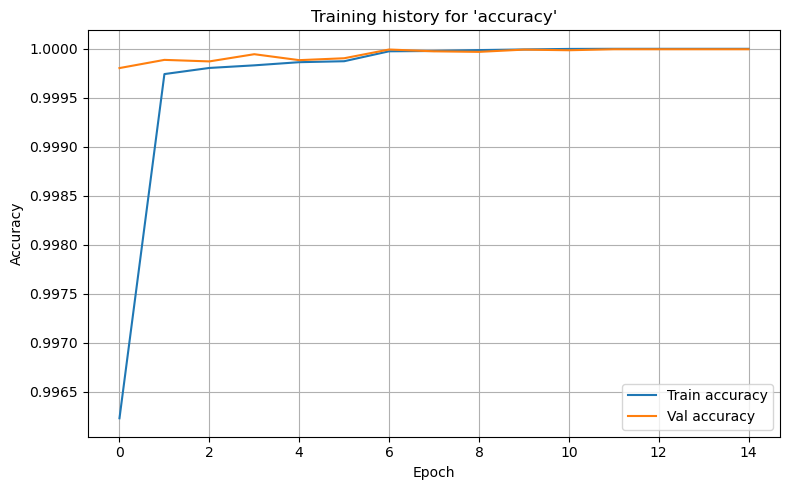

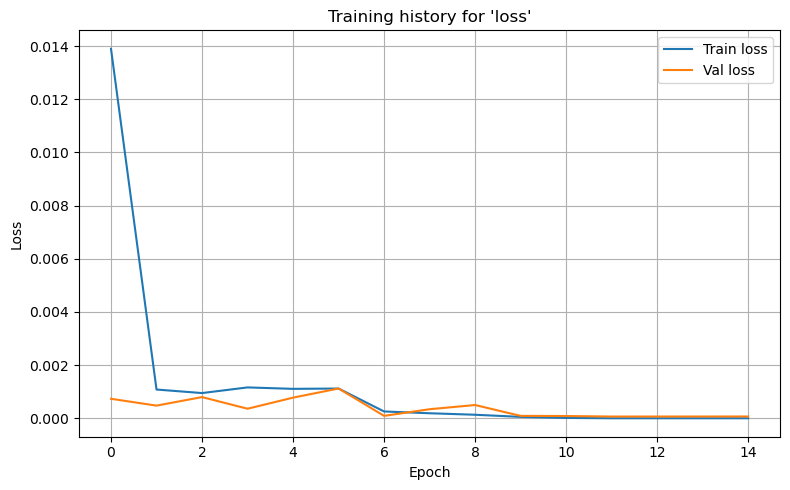

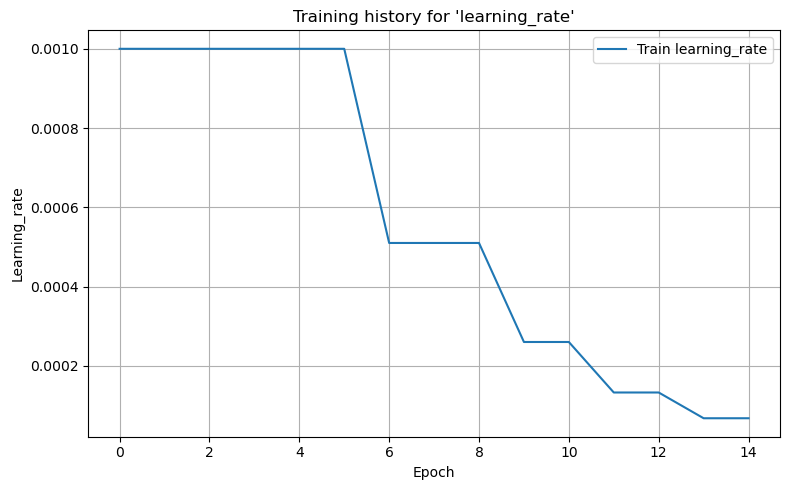

In [11]:
# plot the metriX
hist = history.history
metrics = [key for key in hist.keys() if not key.startswith('val_')]

for metric in metrics:
    plt.figure(figsize=(8, 5))
    plt.plot(hist[metric], label=f"Train {metric}")
    if f"val_{metric}" in hist:
        plt.plot(hist[f"val_{metric}"], label=f"Val {metric}")
    plt.title(f"Training history for '{metric}'")
    plt.xlabel("Epoch")
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

